# Comarison between EMCWF and EPC 15 

Note that:
    1. Comaprison is performed on the year 2019
    2. Imerg dataset is regridded to resolution from ECMWF ensemble
    3. EPC 15 is computed on regridded Imerg dataset
    4. Evaluation based on regridded Imerg dataset


Scripts to download and process ECMWF data and to regrid Imerg data can be found in folder [scripts_download&prepare_data](scripts_download&prepare_data). 

For CRPS of EPC 15 run **crps_year2019_window.py** on regridded Imerg dataset and for CRPS of ECMWF ensemble run **crps_ecmwf.py**

In [2]:
import numpy as np
import xarray as xr
import xskillscore as xs
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.patches as patches
import matplotlib.colors

from scipy.stats import norm

In [2]:
dirpath_ecmwf = 'D:/precip_ecmwf_2019/' 
dirpath_epc15 = 'D:/crps19_epc/' 

In [52]:
crps_ecmwf = xr.open_dataset(dirpath_ecmwf+'crps_ecmwf_2019.nc')
crps_ecmwf = crps_ecmwf.rename({'__xarray_dataarray_variable__':'precipitationCal'})

crps19_15 = xr.open_mfdataset(dirpath_epc15+'regridcrps19_15_*.nc4', concat_dim='time', combine='nested')
crps19_15 = crps19_15.assign_coords(time=crps_ecmwf.time.values)
crps19_15 = crps19_15.transpose('time', 'lat', 'lon')

lat = crps19_15.lat.values
lon = crps19_15.lon.values

Since forecast performance strongly depends on annual precipitation amount different regions are investigated seperatly:
    1. South America: (10N,12.5S,82.5W,52.5W)
    2. Central Africa: (5N,15S, 12.5E, 35E)
    3. North Africa: (18.75N,31N,17.5W, 40E)
    4. Australia: (35S, 20.25S, 110E, 144.75E)
Perform a DM test for regions with high annual precipitation amount: South America and Central Africa

In [3]:
# Compute annual precipitation amount
ds = xr.open_dataset('D:/imergall.nc4')
timeyear = ds.groupby('time.year').sum('time')
sumyears = timeyear.sel(year=np.arange(2001,2020))
sumyears_mean = out.mean('year')
precip = sumyears_mean.precipitationCal.values

landsea = xr.open_dataset('C:/Users/walz/Documents/Work/Promotion/EPC/additional/GPM_IMERG_LandSeaMask.2.nc4')
landsea2 = np.where(landsea.landseamask[:,500:1300].values<100,1,0)
indx_ls = np.where(landsea2 == 0)

# precipitation amount is divided into 11 different classes
ind1 = np.where(np.logical_and(precip>=0, precip<=25))
ind2 = np.where(np.logical_and(precip>25, precip<=50))
ind3 = np.where(np.logical_and(precip>50, precip<=75))
ind4 = np.where(np.logical_and(precip>75, precip<=100))
ind5 = np.where(np.logical_and(precip>100, precip<=150))
ind6 = np.where(np.logical_and(precip>150, precip<=250))
ind7 = np.where(np.logical_and(precip>250, precip<=400))
ind8 = np.where(np.logical_and(precip>400, precip<=800))
ind9 = np.where(np.logical_and(precip>800, precip<=1200))
ind10 = np.where(np.logical_and(precip>1200, precip<=2000))
ind11 = np.where(np.logical_and(precip>2000, precip<=3000))
ind12 = np.where(precip > 3001)

precip[ind1] = 0
precip[ind2] = 1
precip[ind3] = 2
precip[ind4] = 3
precip[ind5] = 4
precip[ind6] = 5
precip[ind7] = 6
precip[ind8] = 7
precip[ind9] = 8
precip[ind10] = 9
precip[ind11] = 10
precip[ind12] = 11

# sea is assigned
precip[indx_ls] = -1

(-120.0, 170.0, -40.0, 40.0)

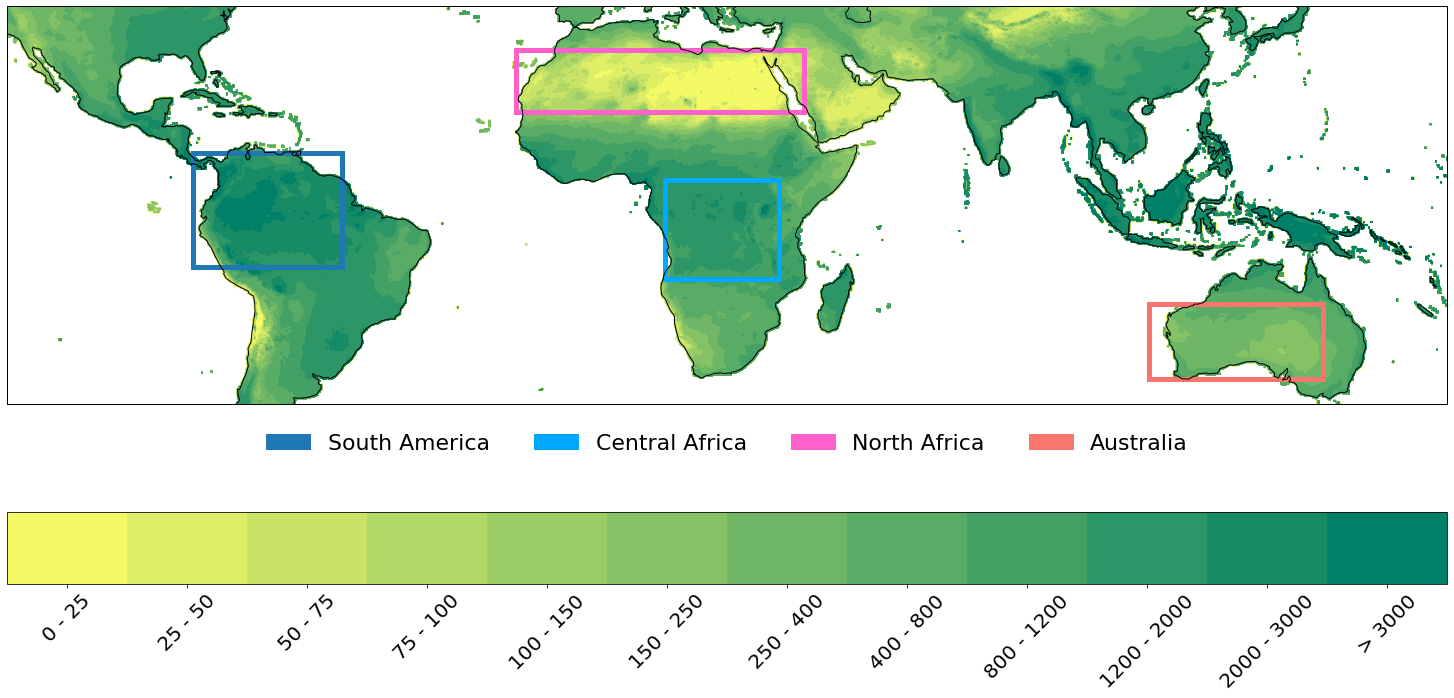

In [4]:
# Plot annual precipitation amount and boxes 
lat = sumyears_mean.lat.values
lon = sumyears_mean.lon.values

precip_plot = np.transpose(precip)

col_gradient = cm.get_cmap('summer', 24)
newcolors = col_gradient(np.linspace(0, 1, 24))
newcolors2 = newcolors[::-1]
newcmp = ListedColormap(newcolors2)

fig, ax = plt.subplots(2,1,figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
cf = plt.contourf(lon, lat, precip_plot, np.arange(-0.5,12,1), cmap=newcmp)
ax1.coastlines()
ax1.set_ylim(-40,40)
ax1.set_xlim(-120,170)

cb = fig.colorbar(cf,orientation='horizontal')
labels = np.arange(-1,12, 1)
loc = labels 
cb.set_ticks(loc)
lables_n = ['0 - 25', '25 - 50','50 - 75','75 - 100','100 - 150','150 - 250','250 - 400','400 - 800','800 - 1200','1200 - 2000','2000 - 3000','> 3000']
cb.set_ticklabels(lables_n)
cb.ax.tick_params(labelsize=20) 
cb.ax.set_xticklabels(lables_n, rotation=45)
cb.ax.tick_params(size=0)

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

rect = patches.Rectangle((110,-35),35,15,linewidth=5,edgecolor='#F8766D',facecolor='none')
ax1.add_patch(rect)
rect = patches.Rectangle((-82.5,-12.5),30,23,linewidth=5,edgecolor='#1f77b4',facecolor='none')
ax1.add_patch(rect)
rect = patches.Rectangle((-17.5,18.75),58,12.5,linewidth=5,edgecolor='#FF61CC',facecolor='none')
ax1.add_patch(rect)
rect = patches.Rectangle((12.5,-15),23,20,linewidth=5,edgecolor='#00A9FF',facecolor='none')
ax1.add_patch(rect)

labels = ['South America', 'Central Africa', 'North Africa', 'Australia']
colors = ["#1f77b4", "#00A9FF", "#FF61CC", "#F8766D"]

patches = [
    patches.Patch(color=color, label=label)
    for label, color in zip(labels, colors)]
ax1.legend(patches, labels, loc='center',ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.1), prop={'size': 22})
plt.axis('off')

In [81]:
def plot_region(lat, lon, xlower, xupper):
    ec1 = crps_ecmwf.sel(lat = lat)
    epc1 = crps19_15.sel(lat = lat)
    ec1 = ec1.sel(lon = lon)
    epc1 = epc1.sel(lon = lon)

    print('Mean CRPS for EPC 15:', np.round(epc1.mean().precipitationCal.values,2))
    print('Mean CRPS for ECMWF:', np.round(ec1.mean().precipitationCal.values,2))

    diff = epc1.mean('time')-ec1.mean('time')
    lonplt = diff.lon.values
    latplt = diff.lat.values
    pltval = diff.precipitationCal.values

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,8), gridspec_kw={'height_ratios': [3, 1]})
    ax1 = plt.axes(projection=ccrs.PlateCarree())
    cf = plt.pcolormesh(lonplt, latplt, pltval) 
    ax1.coastlines()
    minlat = np.min(latplt)
    maxlat = np.max(latplt)
    ax1.set_ylim(-40,40)
    ax1.set_xlim(xlower, xupper)
    h = fig.colorbar(cf,orientation='vertical')
    
def dm_test(lat, lon, alpha=0.05):
    ec1 = crps_ecmwf.sel(lat = lat)
    epc1 = crps19_15.sel(lat = lat)
    ec1 = ec1.sel(lon = lon)
    epc1 = epc1.sel(lon = lon)
    testval = teststatistic(epc1, ec1)
    dimspace = len(lat)*len(lon)
    ds = dimspace/100 
    
    pval = (1-norm.cdf(np.absolute(testval)))*2
    sign_percent = np.min(np.where((np.sort(pval.flatten()) <= np.arange(1,(dimspace+1))*alpha/(dimspace))==False))/(ds)   
    
    rejectval = np.where((np.sort(pval.flatten()) <= np.arange(1,(dimspace+1))*alpha/(dimspace))==False, 0, 1)
    indxpval = np.argsort(pval.flatten())
    
    a = np.column_stack((rejectval,indxpval))
    a = a[a[:,1].argsort()]
    a2 = np.where(a[:,0] == 1)
    testvalflt = testval.flatten()
    sup_percent = np.round(np.sum(testvalflt[a2] < 0)/ds,2)
    
    info = 'Significantly different at'
    print(info, np.round(sign_percent,2), '% of locations. EPC 15 viewed superior at', sup_percent, '% of locations')

    
def teststatistic(epc1, epc2):
    Smean_F = epc1.mean(dim="time")
    Smean_G = epc2.mean(dim="time")
    difference = np.subtract(Smean_F,Smean_G)
    factor = np.sqrt(365)
    variance = np.square(np.subtract(epc1,epc2)).mean(dim="time")
    sigma = np.sqrt(variance)
    teststatistic = factor*np.divide(difference, sigma)
    tt = teststatistic.precipitationCal.values
    return(tt)    

Significantly different at 74.92 % of locations. EPC 15 viewed superior at 74.92 % of locations
Mean CRPS for EPC 15: 4.06
Mean CRPS for ECMWF: 6.15


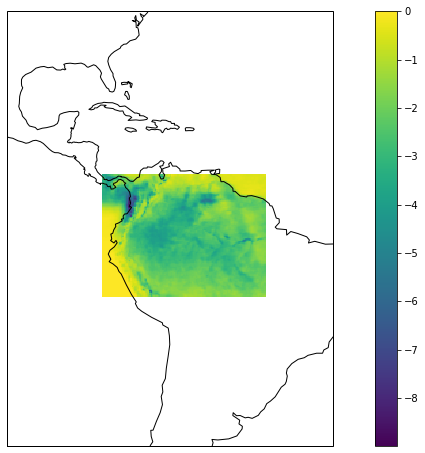

In [82]:
# 1. South America
southAmlat = lat[110:201]
southAmlon = lon[390:511]

dm_test(southAmlat, southAmlon)
plot_region(southAmlat,southAmlon, -100,-40)

Significantly different at 74.17 % of locations. EPC 15 viewed superior at 74.17 % of locations
Mean CRPS for EPC 15: 2.77
Mean CRPS for ECMWF: 4.05


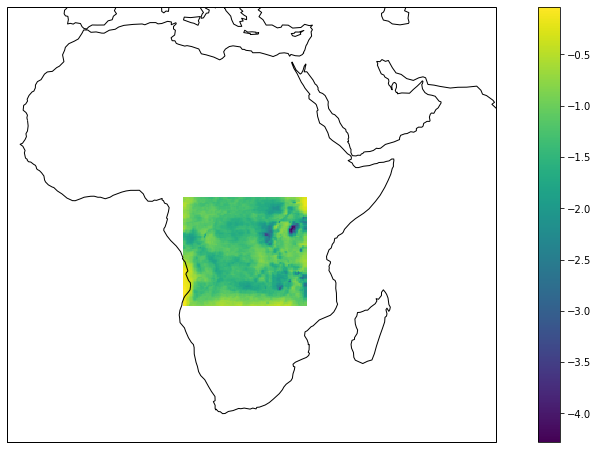

In [83]:
# 2. Central Africa
midAlat = lat[100:181]
midAlon = lon[770:861]
dm_test(midAlat, midAlon)
plot_region(midAlat,midAlon, -20,70)

Mean CRPS for EPC 15: 0.13
Mean CRPS for ECMWF: 0.13


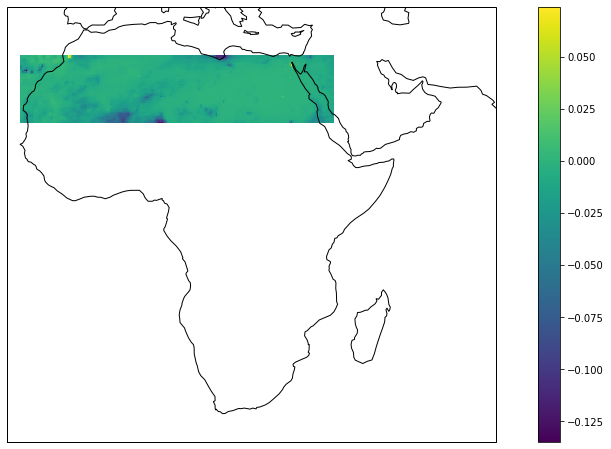

In [84]:
# 3. North Africa
desertlat = lat[235:285]
desertlon = lon[650:881]
plot_region(desertlat, desertlon, -20, 70)

Mean CRPS for EPC 15: 0.49
Mean CRPS for ECMWF: 0.51


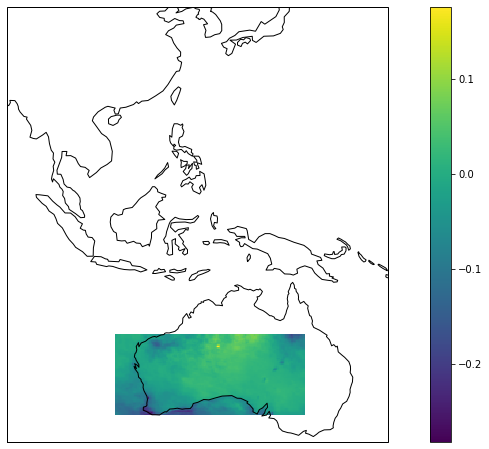

In [85]:
# 4. Australia 
australialat = lat[20:80]
australialon = lon[1160:1300]
plot_region(australialat, australialon, 90, 160)